In [6]:
%%writefile in.tensile.txt
######################################
# LAMMPS INPUT SCRIPT
# Input file for uniaxial tensile loading of single crystal aluminum
# Mark Tschopp
# To execute, use the syntax "lmp_exe < in.tensile.txt" from command prompt

######################################
# VARIABLES
variable n_iter equal 20000

######################################
# INITIALIZATION
units metal
dimension 3
boundary p p p
atom_style atomic
variable latparam equal 4.05

######################################
# ATOM DEFINITION
lattice  fcc ${latparam} orient x 1 0 0 orient y 0 1 0 orient z 0 0 1
region whole block 0 10 0 10 0 10
create_box 1 whole
create_atoms 1 region whole

######################################
# DEFINE INTERATOMIC POTENTIAL
pair_style eam/alloy
pair_coeff * * Al99.eam.alloy Al

######################################
# DEFINE COMPUTES 
compute csym all centro/atom fcc
compute peratom all pe/atom 

######################################
# EQUILIBRATION
reset_timestep 0
timestep 0.001
velocity all create 300 12345 mom yes rot no
fix 1 all npt temp 300 300 1 iso 0 0 1 drag 1 

# Set thermo output
thermo 1000
thermo_style custom step lx ly lz press pxx pyy pzz pe temp

# Run for at least 10 picosecond (assuming 1 fs timestep)
run 10000
unfix 1

# Store final cell length for strain calculations
variable tmp equal "lx"
variable L0 equal ${tmp}
print "Initial Length, L0: ${L0}"

######################################
# DEFORMATION
reset_timestep 0

fix 1 all npt temp 300 300 1 y 0 0 1 z 0 0 1 drag 1
variable srate equal 1.0e10
variable srate1 equal "v_srate / 1.0e12"
fix 2 all deform 1 x erate ${srate1} units box remap x

# Output strain and stress info to file
# for units metal, pressure is in [bars] = 100 [kPa] = 1/10000 [GPa]
# p2, p3, p4 are in GPa
variable strain equal "(lx - v_L0)/v_L0"
variable p1 equal "v_strain"
variable p2 equal "-pxx/10000"
variable p3 equal "-pyy/10000"
variable p4 equal "-pzz/10000"
fix def1 all print 100 "${p1} ${p2} ${p3} ${p4}" file Al_tens_100.def1.txt screen no

# Use cfg for AtomEye
dump 1 all cfg 250 dump.tens_*.cfg mass type xs ys zs c_csym c_peratom fx fy fz
dump_modify 1 element Al

# Display thermo
thermo 1000
thermo_style custom step v_strain temp v_p2 v_p3 v_p4 ke pe press
run 20000

######################################
# SIMULATION DONE
print "All done"

Overwriting in.tensile.txt


In [ ]:
## on Google Colab
#! pip install lmp
#! lmp < in.tensile.txt

In [7]:
!mpirun -np 8 lmp_mpi < in.tensile.txt

LAMMPS (29 Aug 2024 - Update 2)
Lattice spacing in x,y,z = 4.05 4.05 4.05
Created orthogonal box = (0 0 0) to (40.5 40.5 40.5)
  2 by 2 by 2 MPI processor grid
Created 4000 atoms
  using lattice units in orthogonal box = (0 0 0) to (40.5 40.5 40.5)
  create_atoms CPU = 0.007 seconds
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 8.28721
  ghost atom cutoff = 8.28721
  binsize = 4.143605, bins = 10 10 10
  2 neighbor lists, perpetual/occasional/extra = 1 1 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d
      bin: standard
  (2) compute centro/atom, occasional
      attributes: full, newton on
      pair build: full/bin/atomonly
      stencil: full/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory all

In [8]:
import pandas as pd

# Define column names
columns = ['strain', 'stress_xx (GPa)', 'stress_yy (GPa)', 'stress_zz (GPa)']

# Load data while skipping the comment line
df = pd.read_csv('Al_tens_100.def1.txt', 
                 sep='\s+', 
                 comment='#', 
                 names=columns)

df.round(3)

,strain,stress_xx (GPa),stress_yy (GPa),stress_zz (GPa)
0,0.000,0.011,0.009,0.018
1,0.001,0.075,0.001,-0.020
2,0.002,0.138,0.011,-0.007
3,0.003,0.178,0.014,0.007
4,0.004,0.262,-0.002,-0.010
...,...,...,...,...
196,0.196,1.418,-0.140,-0.096
197,0.197,1.491,0.074,0.079
198,0.198,1.316,-0.036,-0.007
199,0.199,1.362,-0.015,0.028


***
## Post-Processing the Simulation 

So, now what?  Why don't we open the `Al_SC_100.def1.txt` file for a stress-strain curve, and then visualize the data from the cfg files to see what is happening with the atoms.

### Stress-Strain Plot

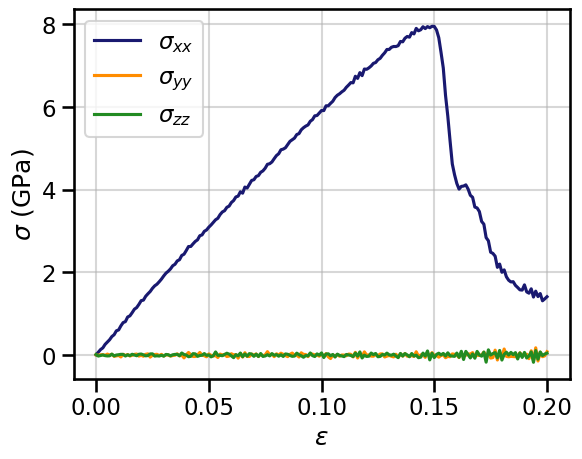

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

sns.lineplot(data=df, x='strain', y='stress_xx (GPa)', label=r'$\sigma_{xx}$', color='midnightblue')
sns.lineplot(data=df, x='strain', y='stress_yy (GPa)', label=r'$\sigma_{yy}$', color='darkorange')
sns.lineplot(data=df, x='strain', y='stress_zz (GPa)', label=r'$\sigma_{zz}$', color='forestgreen')
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\sigma$ (GPa)')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [10]:
import numpy as np

# Use stress_xx for uniaxial tension
strain = df['strain'].values
stress = df['stress_xx (GPa)'].values

# Use first N points (e.g., N = 10) for linear elastic fit
N = 10
coeffs = np.polyfit(strain[:N], stress[:N], 1)
E = coeffs[0]  # Slope of the linear region

print(f"Elastic Modulus E ≈ {E:.2f} GPa")

Elastic Modulus E ≈ 62.92 GPa


### trying to gauge the elastic region from the slope of the curve

In [11]:
df['slope'] = np.gradient(stress, strain)

df.head(10)

,strain,stress_xx (GPa),stress_yy (GPa),stress_zz (GPa),slope
0,1.049404e-15,0.010582,0.009393,0.017659,64.006070
1,1.000000e-03,0.074588,0.001057,-0.019986,63.477688
2,2.000000e-03,0.137538,0.010573,-0.006562,51.707888
3,3.000000e-03,0.178004,0.013678,0.006786,62.345530
4,4.000000e-03,0.262229,-0.002189,-0.009907,69.263037
5,5.000000e-03,0.316530,0.026723,-0.016949,56.175617
6,6.000000e-03,0.374580,0.005959,-0.014126,67.435236
7,7.000000e-03,0.451401,0.023246,0.026806,60.565362
8,8.000000e-03,0.495711,-0.026910,-0.016144,69.582880
9,9.000000e-03,0.590566,-0.016334,0.004882,57.863345


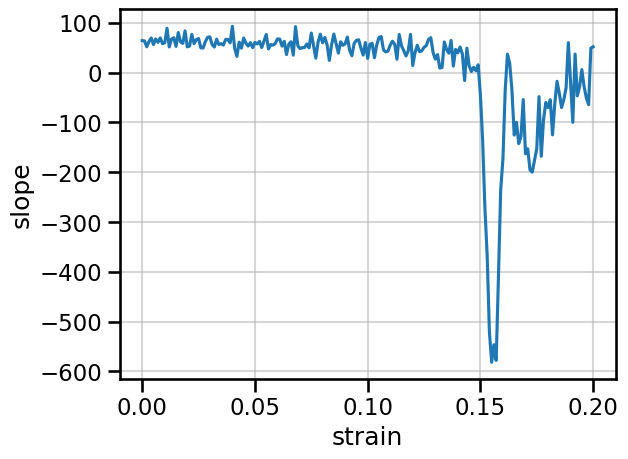

In [12]:
sns.lineplot(data=df, x='strain', y='slope')

plt.grid(alpha=0.5)
plt.show()

In [13]:
import numpy as np

# Use stress_xx for uniaxial tension
strain = df['strain'].values
stress = df['stress_xx (GPa)'].values

# Use first N points (e.g., N = 10) for linear elastic fit
for N in range(10, 110, 10):
    coeffs = np.polyfit(strain[:N], stress[:N], 1)
    E = coeffs[0]  # Slope of the linear region

    print(f"Elastic Modulus N = {N}, strain = {strain[:N][-1].round(2)}, E ≈ {E:.2f} GPa")

Elastic Modulus N = 10, strain = 0.01, E ≈ 62.92 GPa
Elastic Modulus N = 20, strain = 0.02, E ≈ 64.39 GPa
Elastic Modulus N = 30, strain = 0.03, E ≈ 64.09 GPa
Elastic Modulus N = 40, strain = 0.04, E ≈ 63.14 GPa
Elastic Modulus N = 50, strain = 0.05, E ≈ 62.34 GPa
Elastic Modulus N = 60, strain = 0.06, E ≈ 61.42 GPa
Elastic Modulus N = 70, strain = 0.07, E ≈ 60.79 GPa
Elastic Modulus N = 80, strain = 0.08, E ≈ 60.07 GPa
Elastic Modulus N = 90, strain = 0.09, E ≈ 59.57 GPa
Elastic Modulus N = 100, strain = 0.1, E ≈ 59.05 GPa


In [30]:
uts = np.max(stress)
uts_strain = strain[np.argmax(stress)]

print(f"Ultimate Tensile Strength (UTS) ≈ {uts:.2f} GPa at strain ≈ {uts_strain:.4f}")

Ultimate Tensile Strength (UTS) ≈ 7.96 GPa at strain ≈ 0.1480


## open points:
- what else to calculate
- what do we see in ovito?

***
## Making the Deformation Movie 

### Visualization in Windows with OVITO

First download [OVITO](https://www.ovito.org/).
* Go to [OVITO](https://www.ovito.org/).
* Click on download, select operating system, and then create username to download.  Follow remaining instructions to get it on yoru computer.

OK.  Here goes:
* Open [OVITO](https://www.ovito.org/)
* Load file and select the `dump.tens_0.cfg` file.  OVITO will find the rest of the `*.cfg` files.
* Drag the slider bar at the bottom to `64/80` because that is about where the peak of the stress-strain curve above appears.
* Now, go to the `Add modification...` pull down list and select `Color coding`.  Now go to the bottom `Particle property` pulldown list and select `c_csym`.  Now click on adjust range to get a start and end value that is reasonable for viewing the dislocation.
* Click on the play button below to view the evolution of the deformation process.
* To create a movie, click on the `Render Active Viewport` tab up above.  In the `Rendering range` box, select `Complete animation`.  Click on `Save to file` and click on the `Choose...` button (name, "deformation-movie.png").  I like transparent background.  Then click on `Render Active Viewport` at the top for it to render the animation.
* Use ImageJ or whatever you like to pull all the images together into an animated gif or the like to create a movie file.

As a side note:
* If you want, you can `Add Modification...` and select all atoms with low centrosymmetry and delete these atoms from the view.  Unfortunately, the size of the periodic cell is not large enough to be able to view the dislocation nucleation and growth process all that well.  See below for a video with a slightly larger cell size.

For instance, change this to increase the simulation cell size from 10 by 10 by 10 (1000 by 4 atoms = 4000 atoms):
`region whole block 0 10 0 10 0 10`

or double the dimension to increase the number of atoms to 32,000 atoms:
`region whole block 0 20 0 20 0 20`

or increase the dimension to 50 by 50 by 50 to increase the number of atoms to 500,000 atoms:
`region whole block 0 50 0 50 0 50`

</br>
<div class="alert alert-warning">
  <strong>Warning!</strong> Don't expect that this will finish on your laptop very quickly.  Here is where you are going to need multiple processors and/or a supercomputer.
</div>


<br>
<table width="1000" border="0" cellpadding="5">
<tr>

<td width="300" align="center" valign="center">
<figure>
  <img src="https://cavs.msstate.edu/icme/code/lammps/tutorials/lammps/img/350px-Al_SC_100_disl.jpg" width="250" alt="Face-centered Cubic Lattice Structure" title="FCC Lattice Structure">
    <figcaption> Image of nucleated dislocation near peak stress.</figcaption>
</figure>
</td>

<td width="300" align="center" valign="center">
<figure>
  <img src="https://cavs.msstate.edu/icme/code/lammps/tutorials/lammps/img/Al_SC_100_movie1.gif" width="250" alt="Face-centered Cubic Lattice Structure" title="FCC Lattice Structure" />
  <figcaption> Tensile Loading of an Aluminum Single Crystal. Movie showing deformation of single crystal aluminum loaded in the $<100>$ direction at a strain rate of $10^{10}$ $s^{-1}$ and a temperature of 300 K. Only atoms in non-centrosymmetric environment are shown.
  </figcaption>
</figure>
</td>

<td width="300" align="center" valign="center">
<figure>
  <img src="https://cavs.msstate.edu/icme/code/lammps/tutorials/lammps/img/Al_SC_100_movie2.gif" width="250" alt="Face-centered Cubic Lattice Structure" title="FCC Lattice Structure" />
  <figcaption> Tensile Loading of an Aluminum Single Crystal. Movie showing deformation of single crystal aluminum loaded in the <100> direction at a strain rate of $10^{10}$ $s^{-1}$ and a temperature of 300 K.
  </figcaption>
</figure>
</td>
</tr>
</table>
 